In [1]:
%cd /home/pac/gits/phd/mri-online/

/home/pac/gits/phd/mri-online


In [2]:
import os
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy as sp
from mri.operators import FFT,WaveletN, OWL
from modopt.opt.proximity import GroupLASSO, IdentityProx
from modopt.opt.linear import Identity
from online.generators.column import Column2DKspaceGenerator,  DataOnlyKspaceGenerator
from online.reconstructors import OnlineReconstructor
from online.operators import ColumnFFT, LASSO
from project_utils import implot, load_data, create_cartesian_metrics
from online.metrics import ssos, psnr_ssos,ssim_ssos
DATA_DIR = "data/"
RESULT_DIR = "data/results/"
N_JOBS = -1

/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "
/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "


1 (640, 320)


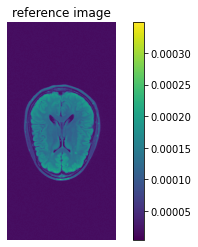

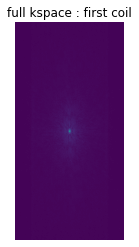

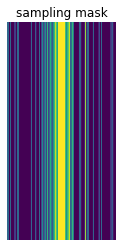

In [3]:
full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,2, monocoil=True,use_ref_kspace=True)
# use mono-coil data
# full_k = sp.fft.fftshift(sp.fft.fft2(real_img,norm="ortho"))
final_k = full_k * final_mask

implot(real_img, "reference image",colorbar=True)
if full_k.ndim == 2:
    implot(np.sqrt(np.abs(full_k)), "full kspace : first coil")
implot(final_mask, "sampling mask")
real_img_size = real_img.shape
square_mask= np.zeros(real_img.shape)
img_size = [min(real_img.shape)]*2
square_mask[real_img_size[0] // 2 - img_size[0] // 2:real_img_size[0] // 2 + img_size[0] // 2,
            real_img_size[1] // 2 - img_size[1] // 2:real_img_size[1] // 2 + img_size[1] // 2] = 1

K_DIM = final_mask.shape
N_COILS = 1 if full_k.ndim == 2 else full_k.shape[0]
print(N_COILS, K_DIM)


# Type I reconstruction
## Monocoil

Making n_jobs = 1 for WaveletN as n_coils = 1


  5%|▌         | 4/80 [00:00<00:02, 34.58it/s]

vanilla


81it [00:01, 43.98it/s]                        


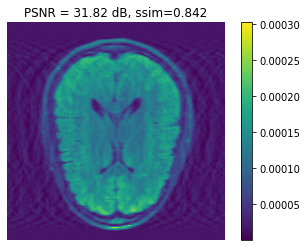

In [4]:
full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,2, monocoil=True,use_ref_kspace=True)
final_k = np.squeeze(full_k * final_mask[np.newaxis,...])

kspace_gen = Column2DKspaceGenerator(final_k, mask_cols=mask_loc)
K_DIM = kspace_gen.shape[-2:]
N_COILS = kspace_gen.shape[0] if full_k.ndim == 3 else 1
# The fourier Operator apply also the sampling mask.
fourier_op = FFT(shape=K_DIM,n_coils=N_COILS, mask=final_mask)
# Wavelets coefficients for each coils
linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=N_JOBS)
# initialisation of wavelet transform
linear_op.op(np.zeros_like(final_k))

# Regularizer definition
if N_COILS ==1:
    GL_op = LASSO(weights=2e-6)
else:
    GL_op = GroupLASSO(weights=2e-6)

OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)
cost_op_kwargs = {'cost_interval': 1}


online_pb = OnlineReconstructor(fourier_op,
                                Identity(),
                                regularizer_op=IdentityProx(),
#                                 linear_op,
#                                 regularizer_op=GL_op,
                                opt='vanilla',
                                verbose=0)

metrics_config = create_cartesian_metrics(online_pb, real_img, final_mask, final_k)

results = online_pb.reconstruct(kspace_gen,
                                eta=1.,
                                #**metrics_config,
                                )
x=ssos(results['x_final'])
psnr = psnr_ssos(x,real_img, mask=square_mask)
ssim = ssim_ssos(x, real_img, mask=square_mask)
implot(ssos(x),title=f"PSNR = {psnr:.2f} dB, ssim={ssim:.3f}",mask=square_mask, colorbar=True);

In [5]:
def plot_metric(results, name, log=False, ax=None):
    if ax == None:
        ax = plt.gca()
    if log:
        plt.semilogy(results['metrics'][name]['index'], results['metrics'][name]['values'],label=name)
    else:
        plt.plot(results['metrics'][name]['index'], results['metrics'][name]['values'],label=name)

    

KeyError: 'data_res_off'

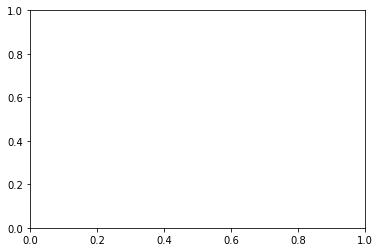

In [6]:
plt.figure()
plot_metric(results,'data_res_off',log=True)
plot_metric(results,'data_res_on',log=True)
plot_metric(results, 'reg_res',log=True)
plt.legend()
fig,axs = plt.subplots(2,1)
plt.sca(axs[0])
plot_metric(results,'psnr',log=False)
plt.sca(axs[1])
plot_metric(results,'ssim',log=True)
plt.legend()


psnr = psnr_ssos(x,real_img,mask=square_mask)
ssim = ssim_ssos(x,real_img,mask=square_mask)

plt.figure()
plt.plot(abs(real_img[320]),label='ref')
plt.plot(abs(ssos(x)[320]),label='xf')
plt.legend()

## Multicoil

In [ ]:
full_k, real_img, mask_loc, final_mask = load_data(DATA_DIR,2, monocoil=False,use_ref_kspace=True)
final_k = np.squeeze(full_k * final_mask[np.newaxis,...])

kspace_gen = Column2DKspaceGenerator(final_k, mask_cols=mask_loc)
K_DIM = kspace_gen.shape[-2:]
N_COILS = kspace_gen.shape[0] if full_k.ndim == 3 else 1
# The fourier Operator apply also the sampling mask.
fourier_op = FFT(shape=K_DIM,n_coils=N_COILS, mask=final_mask)
# Wavelets coefficients for each coils
linear_op = WaveletN("sym8", nb_scale=4, n_coils=N_COILS, n_jobs=N_JOBS)
# initialisation of wavelet transform
linear_op.op(np.zeros_like(full_k))

# Regularizer definition
if N_COILS ==1:
    GL_op = LASSO(weights=2e-6)
else:
    GL_op = GroupLASSO(weights=2e-6)

OWL_op = OWL(alpha=1e-05,
             beta=1e-12,
             bands_shape=linear_op.coeffs_shape,
             mode='band_based',
             n_coils=N_COILS,
             n_jobs=N_JOBS)
cost_op_kwargs = {'cost_interval': 1}


online_pb = OnlineReconstructor(fourier_op,
#                                 Identity(),
#                                 regularizer_op=IdentityProx(),
                                linear_op,
                                regularizer_op=GL_op,
                                opt='vanilla',
                                verbose=0)

metrics_config = create_cartesian_metrics(online_pb, real_img, final_mask, final_k)

results = online_pb.reconstruct(kspace_gen,
                                eta=1.9,
                                **metrics_config,
                                )
x=ssos(results['x_final'])
psnr = psnr_ssos(x,real_img, mask=square_mask)
ssim = ssim_ssos(x, real_img, mask=square_mask)


In [ ]:
plt.figure()
plot_metric(results,'data_res_off',log=True)
plot_metric(results,'data_res_on',log=True)
plot_metric(results, 'reg_res',log=True)
plt.legend()


psnr = psnr_ssos(x,real_img,mask=square_mask)
ssim = ssim_ssos(x,real_img,mask=square_mask)
plt.figure()
implot(ssos(x),title=f"PSNR = {psnr:.2f} dB, ssim={ssim:.3f}",mask=square_mask, colorbar=True);